In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import eden
import matplotlib.pyplot as plt
from eden.util import configure_logging
import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from itertools import tee, chain, islice
import numpy as np
import random
from time import time
import datetime
from graphlearn.graphlearn import Sampler as GraphLearnSampler
from eden.util import fit,estimate
from eden.path import Vectorizer
import random
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
import random
'''
GET RNA DATA
'''
from eden.converter.fasta import fasta_to_sequence
import itertools

def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)
def rfam_uri(family_id):
    return '%s.fa'%(family_id)
 

from eden.converter.fasta import fasta_to_sequence
def get_sequences_with_names(filename='RF00005.fa'):
    sequences = fasta_to_sequence("../toolsdata/"+filename)
    return sequences


def get_graphs(fname,size):
    graphs=[g for g in get_sequences_with_names(fname)]
    random.shuffle(graphs)
    return graphs[:size]

# formerly:
#get_graphs(dataset_fname, size=100)

In [14]:
import random
import graphlearn.abstract_graphs.RNA as rna
from  graphlearn.feasibility import FeasibilityChecker as Checker
from graphlearn.estimator import Wrapper as estimatorwrapper
import graphlearn.utils.draw as draw
from graphlearn.graphlearn import Sampler as GLS
import itertools



def fit_sample(graphs, random_state=random.random()):
    '''
    graphs -> more graphs
    '''
    graphs = list(graphs)
    estimator=estimatorwrapper( nu=.5, cv=2, n_jobs=-1)
    sampler=rna.AbstractSampler(radius_list=[0,1],
                                thickness_list=[2], 
                                min_cip_count=1, 
                                min_interface_count=2, 
                                preprocessor=rna.PreProcessor(base_thickness_list=[1],ignore_inserts=True), 
                                postprocessor=rna.PostProcessor(),
                                estimator=estimator
                                #feasibility_checker=feasibility
                               )
    sampler.fit(graphs,grammar_n_jobs=4,grammar_batch_size=1)
    


    
    
    
    logger.info('graph grammar stats:')
    dataset_size, interface_counts, core_counts, cip_counts = sampler.grammar().size()
    logger.info('#instances:%d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (dataset_size, interface_counts, core_counts, cip_counts))
    
    
    graphs = [ b for a ,b in graphs  ]
    
    graphs = sampler.sample(graphs,
                            n_samples=3,
                            batch_size=1,
                            n_steps=50,
                            n_jobs=4,
                            quick_skip_orig_cip=True,
                            probabilistic_core_choice=True,
                            burnin=10,
                            improving_threshold=0.9,
                            improving_linear_start=0.3,
                            max_size_diff=20,
                            accept_min_similarity=0.65,
                            select_cip_max_tries=30,
                            keep_duplicates=False,
                            include_seed=False,
                            backtrack=10,
                            monitor=False)
    result=[]
    for graphlist in graphs:
        result+=graphlist
    # note that this is a list [('',sequ),..]
    return result

In [15]:
def fit_and_evaluate(pos_original, neg_original,
                     pos_sampled, neg_sampled,
                     pos_test, neg_test,
                     random_state=42):
    '''
    pos + neg orig+sampled testsets -> orig_roc , sampled_roc, augmented_roc
    '''
    
    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = tee(pos_original)
    neg_orig,neg_orig_ = tee(neg_original)
    
    pos_sampled, pos_sampled_ = tee(pos_sampled)
    neg_sampled, neg_sampled_ = tee(neg_sampled)
    
    pos_augmented = chain(pos_orig_,pos_sampled_)
    neg_augmented = chain(neg_orig_,neg_sampled_)

    predictive_performances = []
    for desc,pos_train,neg_train in [('original',pos_orig, neg_orig),
                                     ('sample',pos_sampled,neg_sampled),
                                     ('original+sample',pos_augmented, neg_augmented)]:
        pos_train,pos_train_ = tee(pos_train)
        neg_train,neg_train_ = tee(neg_train)
        pos_size=sum(1 for x in pos_train_)
        neg_size=sum(1 for x in neg_train_)

        logger.info( "-"*80)
        logger.info('working on %s'%(desc))
        logger.info('training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size))

        if pos_size == 0 or neg_size == 0:
            logger.info('WARNING: empty dataset')
            predictive_performances.append(0)            
        else:
            start=time()
            pos_test,pos_test_ = tee(pos_test)
            neg_test,neg_test_ = tee(neg_test)
            
            local_estimator = fit(pos_train, neg_train, Vectorizer(4), n_jobs=-1, n_iter_search=1)
            apr, roc = estimate(pos_test_, neg_test_, local_estimator, Vectorizer(4))
            predictive_performances.append(roc)
            logger.info( 'elapsed: %.1f sec'%(time()-start))
    return predictive_performances

In [16]:
def evaluate(pos_fname, neg_fname, size=None, percentages=None, n_repetitions=None, train_test_split=None):
    # initializing 
    graphs_pos = get_graphs(pos_fname, size=size)
    graphs_neg = get_graphs(neg_fname, size=size)

    # train/test split
    from eden.util import random_bipartition_iter
    pos_train_global,pos_test_global = random_bipartition_iter(graphs_pos,train_test_split,random_state=random.random()*1000)
    neg_train_global,neg_test_global = random_bipartition_iter(graphs_neg,train_test_split,random_state=random.random()*1000)


    original_repetitions = []
    original_sample_repetitions = []
    sample_repetitions = []

    for percentage in percentages:
        originals = []
        originals_samples = []
        samples = []
        for repetition in range(n_repetitions):
            random_state = int(313379*percentage+repetition) 
            random.seed(random_state)
            pos_train_global,pos_train_global_ = tee(pos_train_global)
            neg_train_global,neg_train_global_ = tee(neg_train_global)
            pos_test_global,pos_test_global_ = tee(pos_test_global)
            neg_test_global,neg_test_global_ = tee(neg_test_global)

            # use shuffled list to create test and sample set
            pos,pos_reminder = random_bipartition_iter(pos_train_global_,percentage)
            pos,pos_ = tee(pos)
            neg,neg_reminder = random_bipartition_iter(neg_train_global_,percentage)
            neg,neg_ = tee(neg)

            #sample independently from the 2 classes
            logger.info('Positive')
            sampled_pos = fit_sample(pos_, random_state=random_state)
            logger.info('Negative')
            sampled_neg = fit_sample(neg_, random_state=random_state)

            #evaluate the predictive performance on held out test set
            start=time()
            logger.info( "="*80)
            logger.info( 'repetition: %d/%d'%(repetition+1, n_repetitions))
            logger.info( "training percentage:"+str(percentage))
            perf_orig,\
            perf_samp,\
            perf_orig_samp = fit_and_evaluate(pos,neg,
                                              sampled_pos,sampled_neg,
                                              pos_test_global_,neg_test_global_)
            logger.info( 'Time elapsed for full repetition: %.1f sec'%((time()-start)))
            originals.append(perf_orig)
            originals_samples.append(perf_orig_samp)
            samples.append(perf_samp)

        original_repetitions.append(originals)
        original_sample_repetitions.append(originals_samples)
        sample_repetitions.append(samples)
    
    return original_repetitions, original_sample_repetitions, sample_repetitions

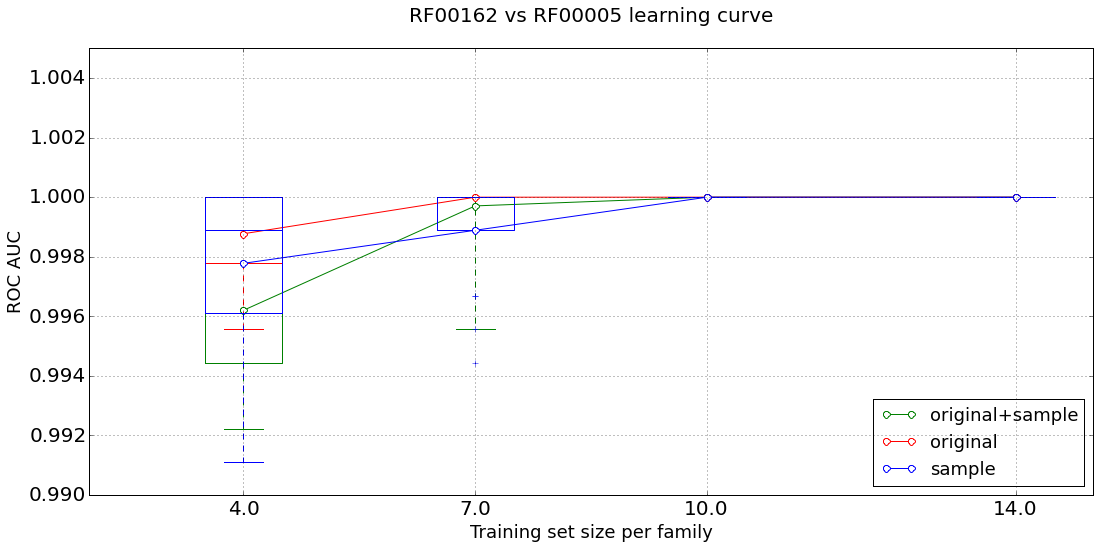

In [54]:
def plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions):
    gc={'color':'g'}
    rc={'color':'r'}
    bc={'color':'b'}
    FONTSIZE=20

    
    ws = 1
    os = np.mean(original_sample_repetitions, axis=1)
    o = np.mean(original_repetitions, axis=1)
    s = np.mean(sample_repetitions, axis=1)
    plt.figure(figsize=(18,8))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(20)
    
    
    plt.grid()
    plt.boxplot(original_sample_repetitions, positions=percentages, widths=ws, capprops=gc, medianprops=gc, boxprops=gc, whiskerprops=gc, flierprops=gc)
    plt.plot(percentages,os, color='g', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='g', markerfacecolor='w', label='original+sample')

    plt.boxplot(original_repetitions, positions=percentages, widths=ws, capprops=rc, medianprops=rc, boxprops=rc, whiskerprops=rc, flierprops=rc)
    plt.plot(percentages,o, color='r', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='r', markerfacecolor='w', label='original')

    plt.boxplot(sample_repetitions, positions=percentages, widths=ws, capprops=bc, medianprops=bc, boxprops=bc, whiskerprops=bc, flierprops=bc)
    plt.plot(percentages,s, color='b', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='b', markerfacecolor='w', label='sample')

    plt.xlim(percentages[0]-.05,percentages[-1]+.05)
    plt.xlim(2,15)
    plt.ylim(0.99,1.005)
    plt.title(dataset+'\n',fontsize=20)
    plt.legend(loc='lower right',fontsize=18)
    plt.ylabel('ROC AUC',fontsize=18)
    plt.xlabel('Training set size per family',fontsize=18)
    plt.savefig('%s_plot_predictive_performance_of_samples.pdf' % dataset)

#load("DATAS")
plot("RF00162 vs RF00005 learning curve", percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

In [18]:
def save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions):
    with open(result_fname,'w') as f:
        f.write('dataset sizes list:\n')
        for perc in percentages:
            f.write('%s '% perc)
        f.write('\n')
        f.write('AUC scores:\n')
        for repetitions in original_repetitions,original_sample_repetitions,sample_repetitions:
            f.write('%s\n' % len(repetitions))
            for repetition in repetitions:
                for auc in repetition:
                    f.write('%s ' % auc)
                f.write('\n')
    
def load_results(result_fname):
    with open(result_fname) as f:
        comment = next(f)
        line = next(f)
        percentages = [float(x) for x in line.split()]
        comment = next(f)

        original_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            original_repetitions.append(repetition)

        original_sample_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            original_sample_repetitions.append(repetition)


        sample_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            sample_repetitions.append(repetition)
            
    return percentages, original_repetitions,original_sample_repetitions,sample_repetitions

#Experimental pipeline

TypeError: There is no line property "fontsize"

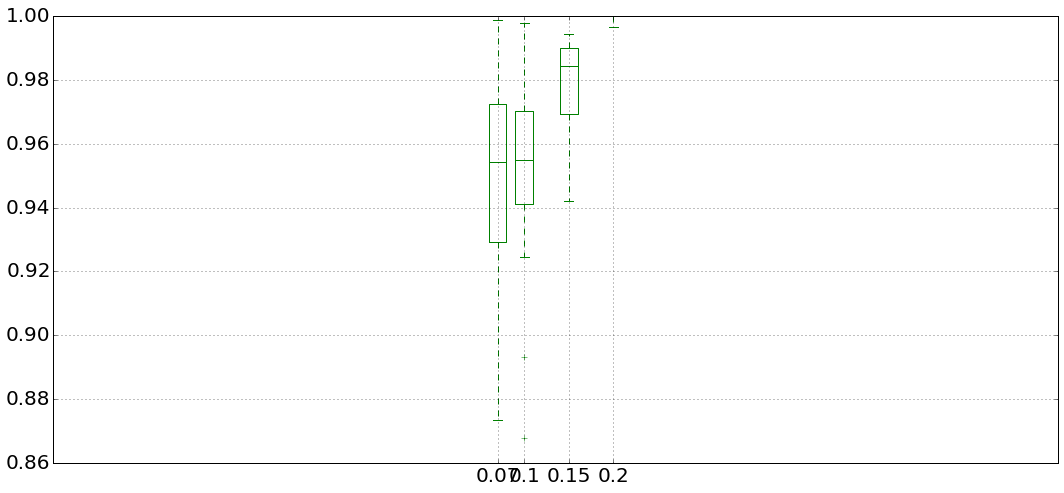

In [32]:
plot("RF00162 vs RF01725", percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

Working with dataset: RF00162 vs RF00005 training curve
Working with dataset: RF00162 vs RF00005 training curve
Time elapsed: 0:00:00.423913
CPU times: user 416 ms, sys: 12 ms, total: 428 ms
Wall time: 425 ms


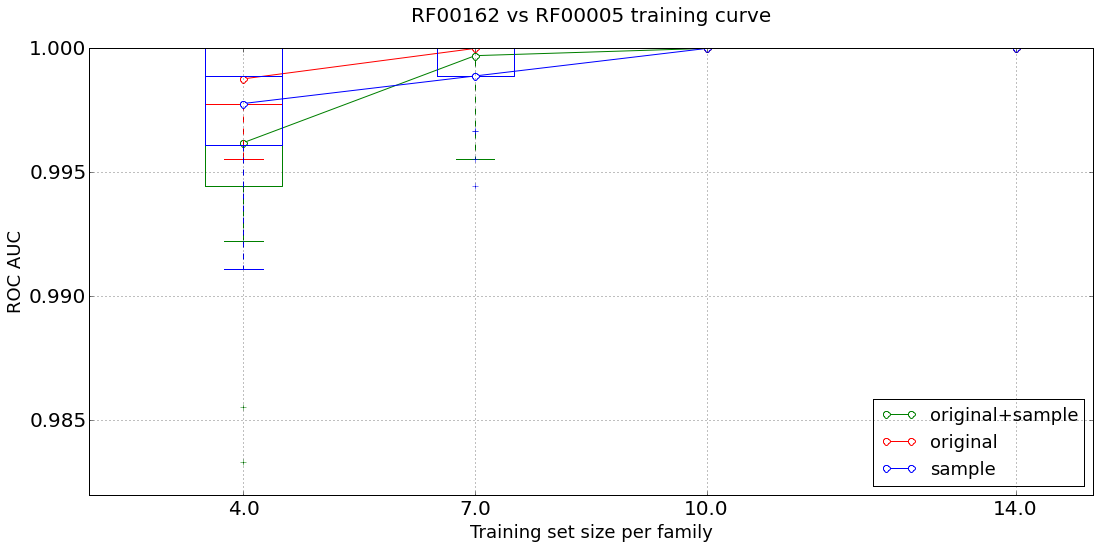

In [49]:
%%time
#special case: bursi

dataset='RF00162 vs RF00005 training curve'
#logging
logger = logging.getLogger()
if True:
    logger_fname = '%s_predictive_performance_of_samples.log'%dataset
else:
    logger_fname = None
configure_logging(logger,verbosity=1, filename=logger_fname)

#main 
start=time()
print( 'Working with dataset: %s' % dataset )

logger.info( 'Working with dataset: %s' % dataset )
pos_dataset_fname = 'RF00005.fa'
neg_dataset_fname = 'mixed.fa'

pos_dataset_fname = 'RF00162.fa'
neg_dataset_fname = 'RF01725.fa'

percentages=[.08,.2,.4,.6,.8,.95]
percentages=[.07,0.1,0.15,0.2]
percentages=[.05]

'''
# set size to 900 in production
original_repetitions,\
original_sample_repetitions,\
sample_repetitions = evaluate(pos_dataset_fname,
                              neg_dataset_fname,
                              size=100,
                              percentages=percentages,
                              n_repetitions=10,
                              train_test_split=0.7)
#save and display results
result_fname='%s_predictive_performance_of_samples.data'%dataset
save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions) 
'''

percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results("datenn.data")
plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

print('Time elapsed: %s'%(datetime.timedelta(seconds=(time() - start))))


In [46]:
!ls

asd.data
backup20x.data
DATENN 
datenn.data
EvaluatePredictivePerformanceOfSamplesCipML-WHOLE.ipynb
EvaluatePredictivePerformanceOfSamples.ipynb
EvaluateProbabilityOfSamples.ipynb
PredictiveRNA-Copy1.ipynb
PredictiveRNA.ipynb
RF00005 vs RF00162_plot_predictive_performance_of_samples.pdf
RF00005 vs RF00162_predictive_performance_of_samples.log
RF00005 vs RF00162+RF01725_plot_predictive_performance_of_samples.pdf
RF00005 vs RF00162+RF01725_predictive_performance_of_samples.log
RF00005 vs RF00162+RF01725_predictive_performance_of_samples.log.1
RF00005 vs RF00162+RF01725_predictive_performance_of_samples.log.10
RF00005 vs RF00162+RF01725_predictive_performance_of_samples.log.2
RF00005 vs RF00162+RF01725_predictive_performance_of_samples.log.3
RF00005 vs RF00162+RF01725_predictive_performance_of_samples.log.4
RF00005 vs RF00162+RF01725_predictive_performance_of_samples.log.5
RF00005 vs RF00162+RF01725_predictive_performance_of_samples.log.6
RF00005 vs RF00162+RF01725_predictive_performance_

In [22]:
%%time
for dataset in dataset_names:
    #logging
    logger = logging.getLogger()
    if True:
        logger_fname = '%s_predictive_performance_of_samples.log'%dataset
    else:
        logger_fname = None
    configure_logging(logger,verbosity=1, filename=logger_fname)
    
    #main 
    start=time()
    print( 'Working with dataset: %s' % dataset )

    logger.info( 'Working with dataset: %s' % dataset )
    pos_dataset_fname = "RF00005.fa"
    neg_dataset_fname = 'mixed.fa

    percentages=[.05,.2,.4,.6,.8,.95]
    percentages=[.05,.2]

    original_repetitions,\
    original_sample_repetitions,\
    sample_repetitions = evaluate(pos_dataset_fname,
                                  neg_dataset_fname,
                                  size=400,
                                  percentages=percentages,
                                  n_repetitions=3,
                                  train_test_split=0.7)
    #save and display results
    result_fname='%s_predictive_performance_of_samples.data'%dataset
    save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions)    
    percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results(result_fname)
    plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)
    
    print('Time elapsed: %s'%(datetime.timedelta(seconds=(time() - start))))


SyntaxError: EOL while scanning string literal (<unknown>, line 16)

In [ ]:
#display
for dataset in dataset_names:
    result_fname='%s_predictive_performance_of_samples.data'%dataset
    percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results(result_fname)
    plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)
    

.